Author: Sridivya Pagadala

#Import packages

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (15, 5)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

# Data preprocessing and EDA

In [ ]:
data= pd.read_csv("https://raw.githubusercontent.com/PSdiv/TimeSeriesAnalysis/main/zillow_data.csv",dtype='str',encoding='latin-1')

In [ ]:
data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31
0,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,06,037,176350.0,176387.0,176455.0,176604.0,176741.0,176920.0,177147.0,177134.0,176973.0,176683.0,176597.0,176495.0,175857.0,175187.0,174673.0,174747.0,174887.0,175009.0,175350.0,176158.0,177013.0,177997.0,178617.0,179652.0,181303.0,183340.0,185143.0,186295.0,187433.0,188365.0,188834.0,...,574949.0,578478.0,582802.0,586489.0,589743.0,592338.0,597217.0,602009.0,606517.0,611025.0,615985.0,620140.0,623195.0,626065.0,628679.0,629432.0,629566.0,630115.0,630790.0,630088.0,629353.0,626334.0,623505.0,622741.0,626397.0,631493.0,632287.0,631886.0,631772.0,634693.0,636618.0,639846.0,643159.0,648559.0,653908.0,658518.0,660247.0,661463.0,666544.0,674103.0
1,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,031,150922.0,150700.0,150354.0,150231.0,149806.0,149865.0,149642.0,149952.0,150412.0,151107.0,151936.0,152499.0,153125.0,153644.0,154310.0,154320.0,155008.0,154946.0,155121.0,153982.0,152423.0,150307.0,148378.0,147319.0,146674.0,146404.0,146421.0,146646.0,146725.0,146843.0,147322.0,...,234650.0,235241.0,235617.0,236413.0,237488.0,238513.0,239180.0,240357.0,242188.0,243706.0,244008.0,244186.0,244746.0,245752.0,246084.0,246320.0,246697.0,247244.0,247905.0,248273.0,248032.0,247892.0,248097.0,248736.0,249197.0,249364.0,249332.0,248938.0,248352.0,247992.0,247675.0,247438.0,247419.0,247619.0,248038.0,248354.0,248754.0,249334.0,250510.0,252048.0
2,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,100906.0,100990.0,101001.0,101154.0,101302.0,101400.0,101437.0,101502.0,101673.0,101874.0,102168.0,102477.0,102406.0,102161.0,101916.0,101931.0,101948.0,102076.0,102257.0,102439.0,102534.0,102624.0,102773.0,102912.0,103521.0,104140.0,104804.0,105001.0,105237.0,105415.0,105638.0,...,182514.0,182932.0,183135.0,183412.0,183827.0,184338.0,184817.0,185223.0,185837.0,186383.0,187009.0,188037.0,189123.0,190084.0,190810.0,191720.0,192783.0,193591.0,194328.0,195044.0,196322.0,197275.0,197569.0,197302.0,197414.0,198085.0,198833.0,199350.0,199600.0,200138.0,200641.0,201191.0,201334.0,201776.0,202686.0,203770.0,204616.0,205126.0,205742.0,206470.0
3,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,04,013,118462.0,118796.0,119174.0,119903.0,120611.0,121250.0,121844.0,122387.0,122923.0,123442.0,123980.0,124513.0,125040.0,125579.0,126065.0,126530.0,126972.0,127418.0,127830.0,128255.0,128738.0,129264.0,129768.0,130262.0,130850.0,131437.0,131982.0,132431.0,132928.0,133458.0,134164.0,...,251531.0,252986.0,254980.0,256258.0,257734.0,259191.0,260947.0,262317.0,264000.0,266125.0,267982.0,269694.0,271453.0,273208.0,274776.0,275961.0,277303.0,278394.0,279326.0,280378.0,281507.0,282710.0,283805.0,284120.0,285207.0,286830.0,288911.0,290621.0,291950.0,293668.0,295749.0,298171.0,300578.0,302803.0,305418.0,308973.0,312112.0,314935.0,317636.0,321242.0
4,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,06,073,183727.0,183369.0,183174.0,182762.0,182573.0,182417.0,182248.0,181983.0,181741.0,181696.0,181716.0,181614.0,181365.0,181358.0,181602.0,182068.0,182380.0,182698.0,183311.0,184319.0,185656.0,18678

###Data preprocessing for Time series Analysis

In [ ]:
# Selecting only IL data for predictions
data_il= data[data['StateName']=='IL']

In [ ]:
# This is Univariate time series analysis hence dropping all other columns
data_cc= data_il.drop(['SizeRank','RegionName','RegionType','StateName','State','Metro','StateCodeFIPS','MunicipalCodeFIPS'],axis=1)

In [ ]:
data_cc=data_cc.transpose()

In [ ]:
data_cc.head()

,1,50,83,87,123,206,217,237,240,306,314,332,361,421,455,518,523,525,533,557,674,778,789,854,872,920,923,926,932,967,972,1005,1009,1178,1193,1195,1198,1220,1237,1269,...,1726,1834,1843,1869,1887,1927,1930,1933,1985,1989,1991,2003,2011,2012,2020,2030,2077,2080,2110,2121,2123,2124,2155,2175,2183,2196,2241,2247,2251,2285,2339,2427,2534,2596,2610,2657,2704,2707,2753,2773
RegionID,139,1682,220,330,197,1922,2877,3122,1900,2648,2526,1314,1186,3119,2572,1835,2371,2363,620,1657,2865,356,3079,1797,2871,392,453,259,208,555,1068,2396,3034,2276,2956,2739,2602,1625,1021,83,...,1699,1672,2229,1750,495,765,102,1472,2380,788,684,990,1197,274,440,2502,1182,1592,2447,3054,626,807,160,1055,121,108,1194,2407,1820,1461,2909,1116,2317,2531,2717,1686,1340,728,1574,297
1996-01-31,150922.0,169762.0,NaN,145507.0,159651.0,159215.0,90798.0,NaN,NaN,NaN,NaN,NaN,108633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52663.0,NaN,NaN,57692.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-29,150700.0,169928.0,NaN,145457.0,159364.0,159732.0,90870.0,NaN,67072.0,NaN,NaN,NaN,108755.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52747.0,NaN,NaN,57753.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-31,150354.0,170132.0,NaN,145409.0,159175.0,160045.0,90934.0,NaN,68012.0,NaN,NaN,NaN,108891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44344.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52716.0,NaN,NaN,57810.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-30,150231.0,170465.0,NaN,145396.0,158750.0,160695.0,91119.0,NaN,68696.0,NaN,NaN,NaN,109141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52733.0,NaN,NaN,57971.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
new_header=data_cc.iloc[0] ## grab first row for new header
data_cc=data_cc[1:] ## take all data after first row
data_cc.columns=new_header ## assign all columns as previous dataframe's first row

In [ ]:
# Converting index to data time format
data_cc.index=pd.to_datetime(data_cc.index)

In [ ]:
data_cc['1996-01-31':'1996-05-31']

RegionID,139,1682,220,330,197,1922,2877,3122,1900,2648,2526,1314,1186,3119,2572,1835,2371,2363,620,1657,2865,356,3079,1797,2871,392,453,259,208,555,1068,2396,3034,2276,2956,2739,2602,1625,1021,83,...,1699,1672,2229,1750,495,765,102,1472,2380,788,684,990,1197,274,440,2502,1182,1592,2447,3054,626,807,160,1055,121,108,1194,2407,1820,1461,2909,1116,2317,2531,2717,1686,1340,728,1574,297
1996-01-31,150922.0,169762.0,NaN,145507.0,159651.0,159215.0,90798.0,NaN,NaN,NaN,NaN,NaN,108633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52663.0,NaN,NaN,57692.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-29,150700.0,169928.0,NaN,145457.0,159364.0,159732.0,90870.0,NaN,67072.0,NaN,NaN,NaN,108755.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52747.0,NaN,NaN,57753.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-31,150354.0,170132.0,NaN,145409.0,159175.0,160045.0,90934.0,NaN,68012.0,NaN,NaN,NaN,108891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44344.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52716.0,NaN,NaN,57810.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-30,150231.0,170465.0,NaN,145396.0,158750.0,160695.0,91119.0,NaN,68696.0,NaN,NaN,NaN,109141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52733.0,NaN,NaN,57971.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-31,149806.0,170857.0,NaN,145383.0,158322.0,161080.0,91332.0,NaN,69822.0,NaN,NaN,NaN,109462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52503.0,NaN,NaN,58095.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###Handling missing values

In [ ]:
df_nan= pd.DataFrame(data_cc.isna().sum(),columns=['NanRows'])

In [ ]:
regions_noMissingData = df_nan[df_nan['NanRows']==0].index
regions_withMissingData = df_nan[df_nan['NanRows']>0].index

In [ ]:
regions_withMissingData

Index(['220', '3122', '1900', '2648', '2526', '1314', '3119', '2572', '1835',
       '2371', '2363', '620', '1657', '356', '3079', '1797', '2871', '392',
       '453', '259', '208', '555', '1068', '3034', '2276', '2739', '2602',
       '1625', '1021', '83', '1232', '896', '2657', '2690', '2492', '1217',
       '606', '2971', '2355', '1363', '1124', '2945', '1383', '676', '1699',
       '1672', '2229', '1750', '495', '765', '102', '1472', '788', '684',
       '990', '1197', '274', '440', '2502', '1182', '1592', '2447', '3054',
       '626', '807', '160', '1055', '121', '108', '1194', '2407', '1820',
       '1461', '2909', '1116', '2317', '2531', '2717', '1686', '1340', '728',
       '1574', '297'],
      dtype='object', name='RegionID')

In [ ]:
# Using backward fill
for col in regions_withMissingData:
  data_cc[col]=data_cc[col].fillna(method='bfill')

In [ ]:
data_cc.isna().sum()

RegionID
139     0
1682    0
220     0
330     0
197     0
       ..
1686    0
1340    0
728     0
1574    0
297     0
Length: 95, dtype: int64

In [ ]:
## cast all prices from strings to float
## cast all prices from floats to integers
data_cc=data_cc.astype(float)
data_cc=data_cc.astype(int)

##EDA

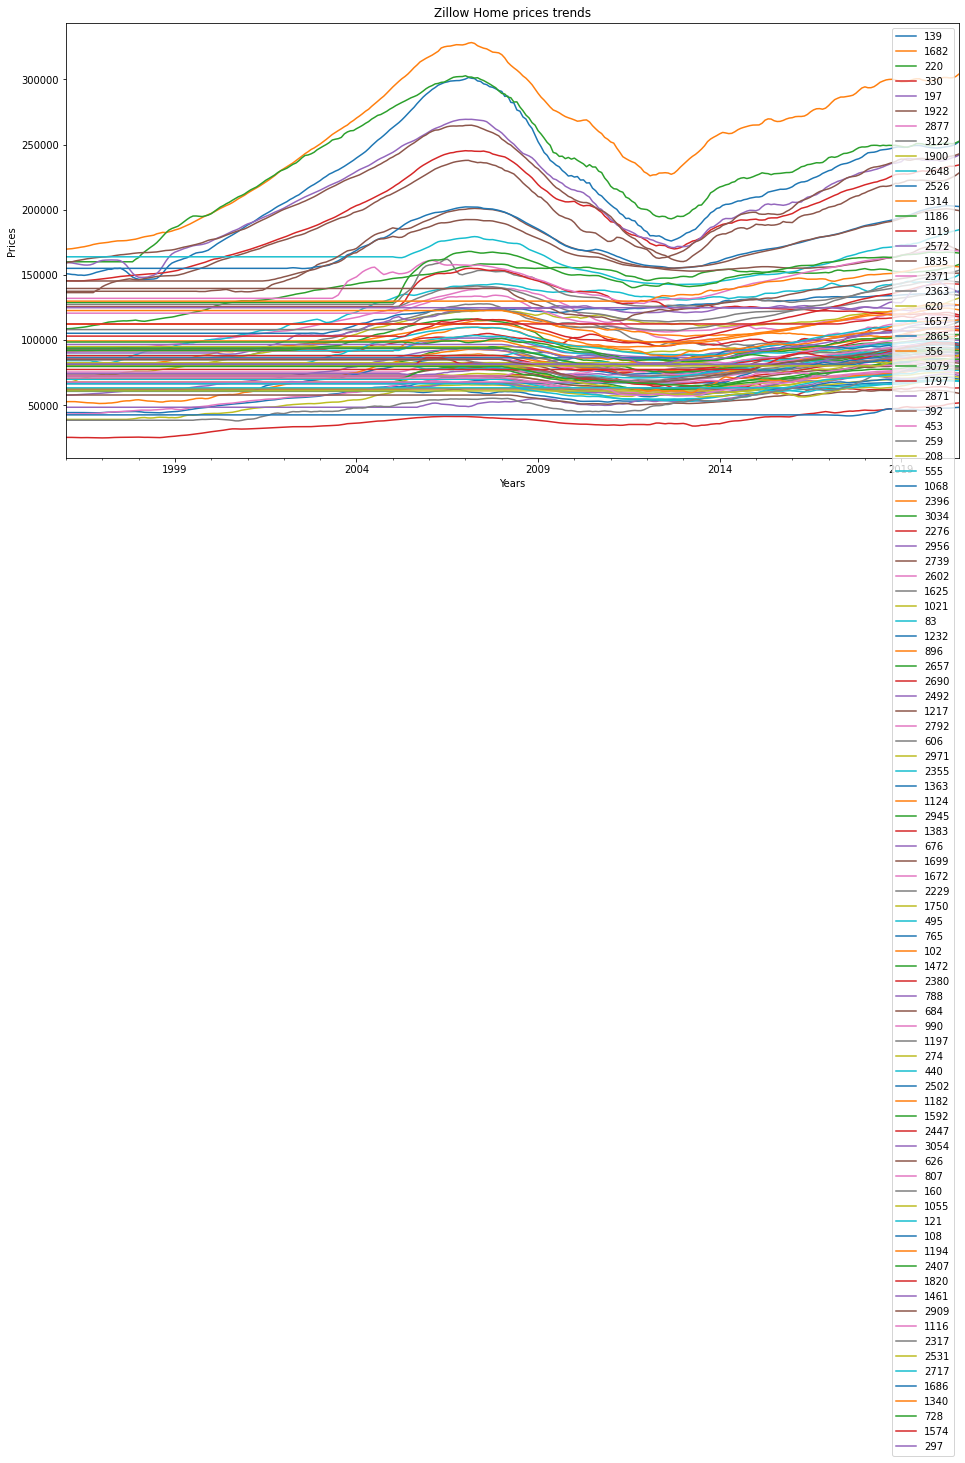

In [ ]:
data_cc.plot(figsize=(16,8))
plt.title("Zillow Home prices trends")
plt.xlabel("Years")
plt.ylabel("Prices")
plt.legend()
plt.show()

#Train Test split

In [ ]:
train=data_cc[(data_cc.index.get_level_values(0) >= '1993-01-31') & (data_cc.index.get_level_values(0) <= '2019-01-31')]
test=data_cc[(data_cc.index.get_level_values(0) > '2019-01-31')]

#Stationarity check, AR, MA, ARIMA

In [ ]:

# Function for checking stationarity of data (Dickey Fuller test for stationarity)
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, 24).mean()
    rolstd = pd.Series.rolling(timeseries, 24).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

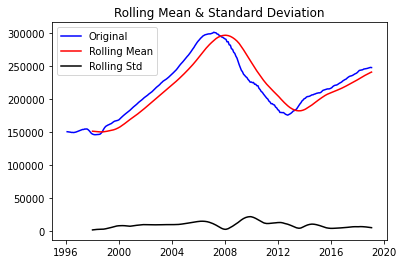

Results of Dickey-Fuller Test:
Test Statistic                  -2.653842
p-value                          0.082372
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [ ]:
test_stationarity(train['139'])

In [ ]:
'''Make a Time Series Stationary'''
# Estimating & Eliminating Trend

Train_log = np.log(train['139'])
valid_log = np.log(test['139'])

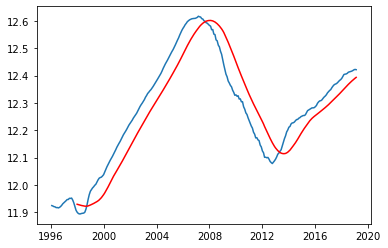

In [ ]:
# Taking rolling mean
moving_avg = pd.Series.rolling(Train_log, 24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

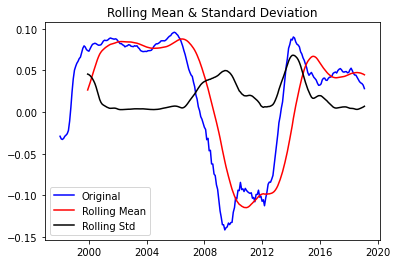

Results of Dickey-Fuller Test:
Test Statistic                  -2.167139
p-value                          0.218387
#Lags Used                      14.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


In [ ]:
# Removing trend
train_log_moving_avg_diff = Train_log - moving_avg

train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

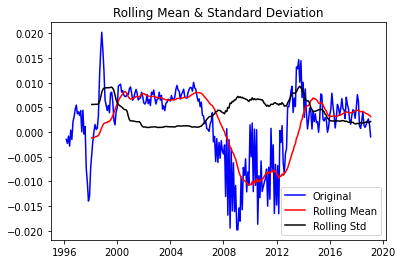

Results of Dickey-Fuller Test:
Test Statistic                  -1.428630
p-value                          0.568476
#Lags Used                      16.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [ ]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

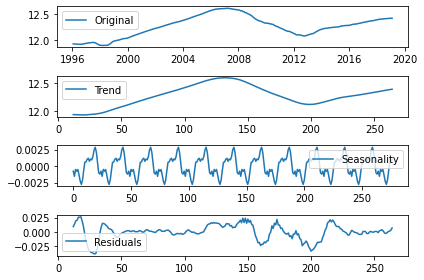

In [ ]:
# Decomposing the time series into trend, seasonality and residual
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log)['139'].values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

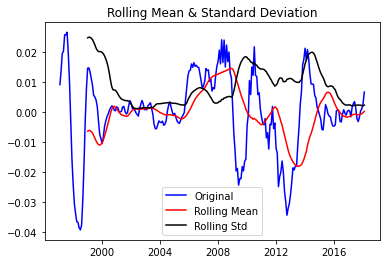

Results of Dickey-Fuller Test:
Test Statistic                  -3.399515
p-value                          0.010975
#Lags Used                      14.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [ ]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_decompose.dropna(), nlags=25)
lag_pacf = pacf(train_log_decompose.dropna(), nlags=25, method='ols')

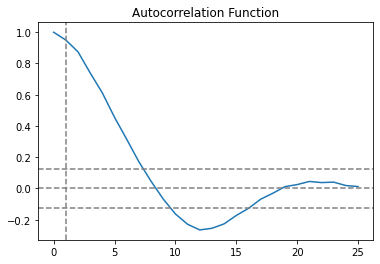

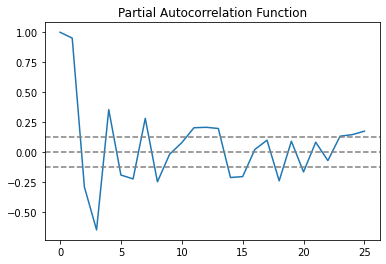

In [ ]:
# Plotting ACF and PACF

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_decompose.dropna())),linestyle='--',color='gray')
plt.axvline(x=1,linestyle='--',color='gray')

plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_decompose.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



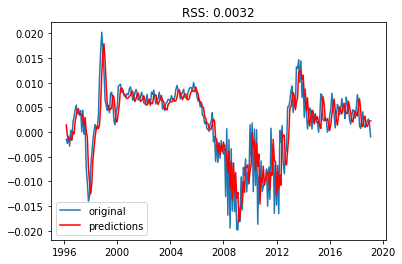

In [ ]:

# Building AR, ARIMA Models

from statsmodels.tsa.arima_model import ARIMA

# AR model
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model
results_AR = model.fit(disp=-1)  
plt.figsize=(15,6)
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')
plt.legend(loc='best')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_log_diff.dropna())**2))
plt.show()

In [ ]:
# predicting using AR model
AR_predict = results_AR.predict(start="2019-02-28", end="2020-08-31")
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(test.shape[0]) * np.log(test['139'])[0], index = test.index)
AR_predict1 = AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

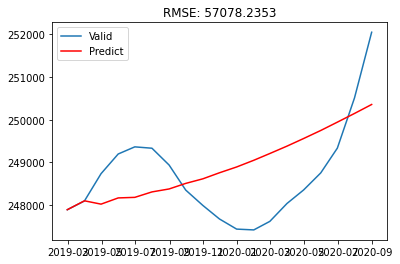

In [ ]:
# Validating the AR model
plt.plot(test['139'], label = "Valid")
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, test['139']))/test.shape[0]))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



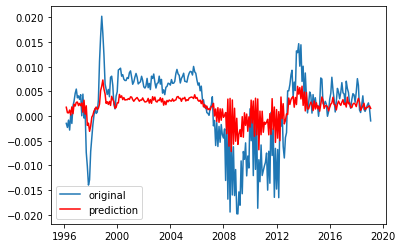

In [ ]:
# MA model
ARIMA = ARIMA(Train_log, order=(0, 1, 1))  # here the p value is zero since it is just the MA model
results_MA = ARIMA.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')
plt.legend(loc='best')
plt.show()

In [ ]:

# predicting using MA model
MA_predict=results_MA.predict(start="2019-02-28", end="2020-08-31")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(test.shape[0]) * np.log(test['139'])[0], index = test.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

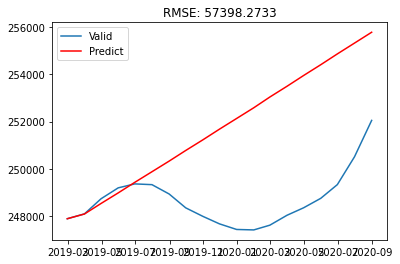

In [ ]:

# validating the MA model
plt.plot(test['139'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, test['139']))/test.shape[0]))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



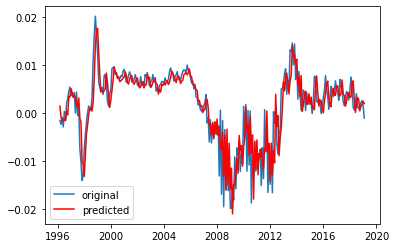

In [ ]:
#Building AR, ARIMA Models

from statsmodels.tsa.arima_model import ARIMA

# ARIMA model
model = ARIMA(Train_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

In [ ]:
# Rescaling the values to otriginal
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['139'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['139'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['139']))/given_set.shape[0]))
    plt.show()

In [ ]:
# predicting using ARIMA
ARIMA_predict_diff=results_ARIMA.predict(start="2019-02-28", end="2020-08-31")

In [ ]:
ARIMA_predict_diff

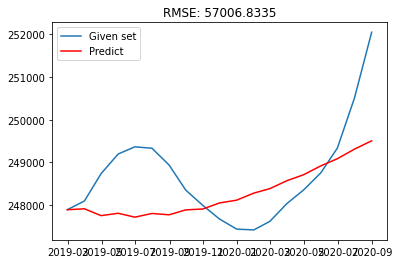

In [ ]:
# validating the predictions
check_prediction_diff(ARIMA_predict_diff, test)

#SARIMAX

In [ ]:
# !pip install pmdarima

In [ ]:
import pmdarima as pm

def collect_models(df):
  regions=df.columns[:2]
  modelsRegions= dict()
  for region in regions:
    model = pm.auto_arima(df[region], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True, 
                      stepwise=True, trace=True)
    modelsRegions[region]= model.get_params()
  return modelsRegions

In [ ]:
models= collect_models(data_cc)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=4946.186, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=4945.314, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=4934.635, Time=0.34 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=4935.081, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=4934.592, Time=0.09 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=4934.523, Time=0.47 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=4935.182, Time=1.05 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=4933.025, Time=1.43 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=4934.494, Time=5.01 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=4948.309, Time=0.34 sec
 ARIMA(2,2,0)(0,0,2)[12]             : AIC=4933.169, Time=1.96 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=4928.922, Time=2.72 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=4930.398, Time=1.05 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=inf, Time=4.67 sec
 ARIMA(1,2,1)(1,0,1)[12]

In [ ]:
import pmdarima as pm

model = pm.auto_arima(train['139'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True, 
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=4644.365, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=4643.118, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=4634.125, Time=0.33 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=4634.460, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=4633.795, Time=0.08 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=4634.037, Time=0.47 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=4634.430, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=4631.024, Time=0.30 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=4631.070, Time=0.98 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=4630.965, Time=1.07 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=4644.944, Time=3.93 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=inf, Time=4.63 sec
 ARIMA(2,2,1)(0,0,1)[12]          

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



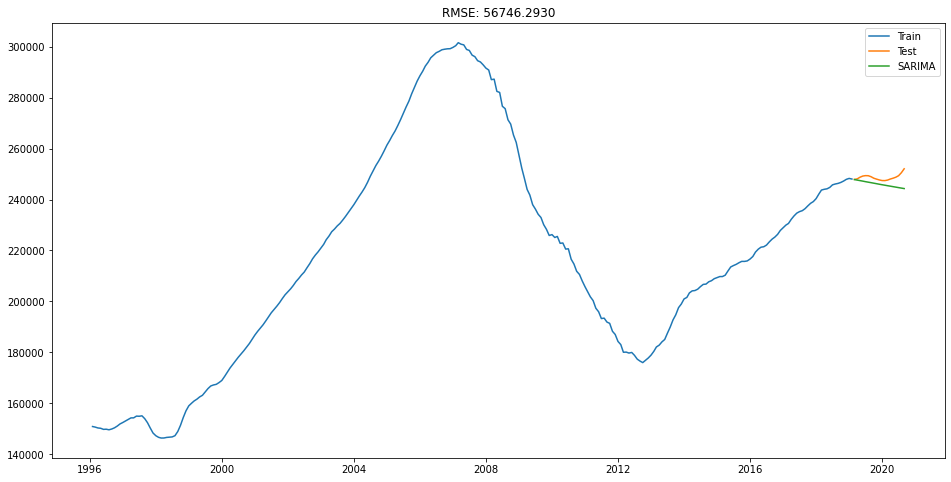

In [ ]:

# Sarimax Model

import statsmodels.api as sm

# SARIMAX model 
y_hat_avg = test.copy()
SARIMA = sm.tsa.statespace.SARIMAX(train['139'], order=(1,2,1),seasonal_order=(0,0,1,12))
fit1 = SARIMA.fit()
y_hat_avg['SARIMA'] = fit1.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
plt.figure(figsize=(16,8))
plt.plot( train['139'], label='Train')
plt.plot(test['139'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(y_hat_avg['SARIMA'], test['139']))/test.shape[0]))
plt.legend(loc='best')
plt.show()

##SARIMAX Forecast

In [ ]:
SARIMA = sm.tsa.statespace.SARIMAX(data_cc['139'], order=(1,2,1),seasonal_order=(0,0,1,12))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



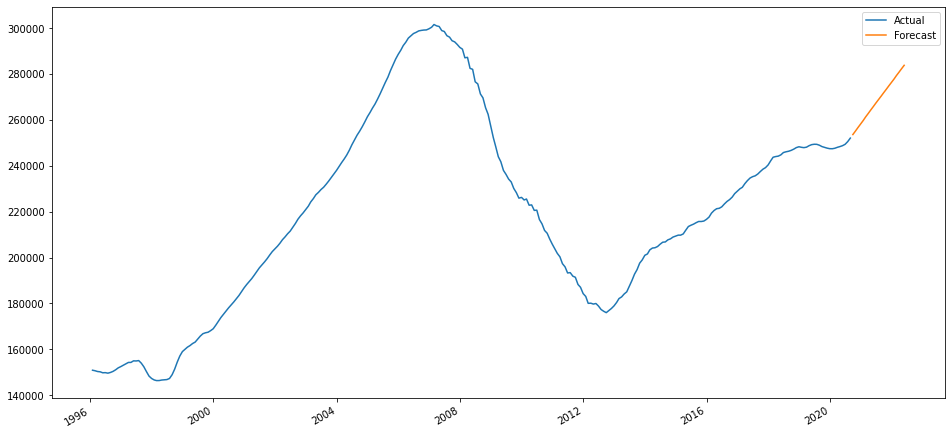

In [ ]:
fit1 = SARIMA.fit()
y_hat_avg= fit1.predict(len(data_cc),len(data_cc)+20, typ='levels')
plt.figure(figsize=(16,8))
plt.plot( data_cc['139'], label='Actual')
y_hat_avg.plot(legend=True,label='Forecast')
plt.legend(loc='best')
plt.show()


#AWS DeepAR

## Creating dummy data

In [ ]:
date_range= pd.date_range(start = pd.to_datetime('1993-01-31'),end=pd.to_datetime('1995-12-31'),freq='M')

In [ ]:
dummy_data=pd.DataFrame(index=date_range,columns=data_cc.columns)

In [ ]:
dummy_data = dummy_data.append(data_cc.head(1))

In [ ]:
for col in data_cc.columns:
  dummy_data[col]=dummy_data[col].fillna(method='bfill')

In [ ]:
dummy_data.head()

RegionID,139,1682,220,330,197,1922,2877,3122,1900,2648,2526,1314,1186,3119,2572,1835,2371,2363,620,1657,2865,356,3079,1797,2871,392,453,259,208,555,1068,2396,3034,2276,2956,2739,2602,1625,1021,83,...,1699,1672,2229,1750,495,765,102,1472,2380,788,684,990,1197,274,440,2502,1182,1592,2447,3054,626,807,160,1055,121,108,1194,2407,1820,1461,2909,1116,2317,2531,2717,1686,1340,728,1574,297
1993-01-31,150922.0,169762.0,160076.0,145507.0,159651.0,159215.0,90798.0,86010.0,67072.0,84229.0,105200.0,81434.0,108633.0,92478.0,90074.0,136413.0,120631.0,127312.0,94926.0,163886.0,44325.0,91653.0,80448.0,125620.0,91849.0,137437.0,75471.0,125206.0,61814.0,92038.0,155034.0,52663.0,92165.0,72685.0,57692.0,73094.0,132019.0,108031.0,67965.0,80171.0,...,72304.0,72421.0,62434.0,82622.0,69888.0,86343.0,99327.0,70670.0,25306.0,48423.0,139588.0,85499.0,93644.0,60965.0,80648.0,67177.0,62706.0,98478.0,80287.0,96605.0,57840.0,67757.0,84713.0,79920.0,66469.0,80966.0,129874.0,93863.0,77421.0,81551.0,85317.0,70859.0,38457.0,80153.0,63295.0,42564.0,112196.0,79727.0,112357.0,124807.0
1993-02-28,150922.0,169762.0,160076.0,145507.0,159651.0,159215.0,90798.0,86010.0,67072.0,84229.0,105200.0,81434.0,108633.0,92478.0,90074.0,136413.0,120631.0,127312.0,94926.0,163886.0,44325.0,91653.0,80448.0,125620.0,91849.0,137437.0,75471.0,125206.0,61814.0,92038.0,155034.0,52663.0,92165.0,72685.0,57692.0,73094.0,132019.0,108031.0,67965.0,80171.0,...,72304.0,72421.0,62434.0,82622.0,69888.0,86343.0,99327.0,70670.0,25306.0,48423.0,139588.0,85499.0,93644.0,60965.0,80648.0,67177.0,62706.0,98478.0,80287.0,96605.0,57840.0,67757.0,84713.0,79920.0,66469.0,80966.0,129874.0,93863.0,77421.0,81551.0,85317.0,70859.0,38457.0,80153.0,63295.0,42564.0,112196.0,79727.0,112357.0,124807.0
1993-03-31,150922.0,169762.0,160076.0,145507.0,159651.0,159215.0,90798.0,86010.0,67072.0,84229.0,105200.0,81434.0,108633.0,92478.0,90074.0,136413.0,120631.0,127312.0,94926.0,163886.0,44325.0,91653.0,80448.0,125620.0,91849.0,137437.0,75471.0,125206.0,61814.0,92038.0,155034.0,52663.0,92165.0,72685.0,57692.0,73094.0,132019.0,108031.0,67965.0,80171.0,...,72304.0,72421.0,62434.0,82622.0,69888.0,86343.0,99327.0,70670.0,25306.0,48423.0,139588.0,85499.0,93644.0,60965.0,80648.0,67177.0,62706.0,98478.0,80287.0,96605.0,57840.0,67757.0,84713.0,79920.0,66469.0,80966.0,129874.0,93863.0,77421.0,81551.0,85317.0,70859.0,38457.0,80153.0,63295.0,42564.0,112196.0,79727.0,112357.0,124807.0
1993-04-30,150922.0,169762.0,160076.0,145507.0,159651.0,159215.0,90798.0,86010.0,67072.0,84229.0,105200.0,81434.0,108633.0,92478.0,90074.0,136413.0,120631.0,127312.0,94926.0,163886.0,44325.0,91653.0,80448.0,125620.0,91849.0,137437.0,75471.0,125206.0,61814.0,92038.0,155034.0,52663.0,92165.0,72685.0,57692.0,73094.0,132019.0,108031.0,67965.0,80171.0,...,72304.0,72421.0,62434.0,82622.0,69888.0,86343.0,99327.0,70670.0,25306.0,48423.0,139588.0,85499.0,93644.0,60965.0,80648.0,67177.0,62706.0,98478.0,80287.0,96605.0,57840.0,67757.0,84713.0,79920.0,66469.0,80966.0,129874.0,93863.0,77421.0,81551.0,85317.0,70859.0,38457.0,80153.0,63295.0,42564.0,112196.0,79727.0,112357.0,124807.0
1993-05-31,150922.0,169762.0,160076.0,145507.0,159651.0,159215.0,90798.0,86010.0,67072.0,84229.0,105200.0,81434.0,108633.0,92478.0,90074.0,136413.0,120631.0,127312.0,94926.0,163886.0,44325.0,91653.0,80448.0,125620.0,91849.0,137437.0,75471.0,125206.0,61814.0,92038.0,155034.0,52663.0,92165.0,72685.0,57692.0,73094.0,132019.0,108031.0,67965.0,80171.0,...,72304.0,72421.0,62434.0,82622.0,69888.0,86343.0,99327.0,70670.0,25306.0,48423.0,139588.0,85499.0,93644.0,60965.0,80648.0,67177.0,62706.0,98478.0,80287.0,96605.0,57840.0,67757.0,84713.0,79920.0,66469.0,80966.0,129874.0,93863.0,77421.0,81551.0,85317.0,70859.0,38457.0,80153.0,63295.0,42564.0,112196.0,79727.0,112357.0,124807.0


In [ ]:
data_cc =pd.concat([dummy_data,data_cc],ignore_index=False)

In [ ]:
import json

In [ ]:

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))


In [ ]:
list(data_cc['139'][:5])


[150922, 150700, 150354, 150231, 149806]

In [ ]:
series_to_obj(data_cc['139'][:5],None)


{'start': '1996-01-31 00:00:00',
 'target': [150922, 150700, 150354, 150231, 149806]}

In [ ]:

series_to_jsonline(data_cc['139'][:5],None)


'{"start": "1996-01-31 00:00:00", "target": [150922, 150700, 150354, 150231, 149806]}'

In [ ]:
train

In [ ]:
encoding = "utf-8"
cat_idx = 0

train_file_name = "train.json"
test_file_name = "test.json"


with open(train_file_name, 'wb') as fp:
    for ts in [train['139']]:
        fp.write(series_to_jsonline(ts,None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [ ]:
with open(test_file_name, 'wb') as fp:
    for ts in [data_cc['139']]:
        fp.write(series_to_jsonline(ts,None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [ ]:
data_cc

RegionID,139,1682,220,330,197,1922,2877,3122,1900,2648,2526,1314,1186,3119,2572,1835,2371,2363,620,1657,2865,356,3079,1797,2871,392,453,259,208,555,1068,2396,3034,2276,2956,2739,2602,1625,1021,83,...,1699,1672,2229,1750,495,765,102,1472,2380,788,684,990,1197,274,440,2502,1182,1592,2447,3054,626,807,160,1055,121,108,1194,2407,1820,1461,2909,1116,2317,2531,2717,1686,1340,728,1574,297
1996-01-31,150922,169762,160076,145507,159651,159215,90798,86010,67072,84229,105200,81434,108633,92478,90074,136413,120631,127312,94926,163886,44325,91653,80448,125620,91849,137437,75471,125206,61814,92038,155034,52663,92165,72685,57692,73094,132019,108031,67965,80171,...,72304,72421,62434,82622,69888,86343,99327,70670,25306,48423,139588,85499,93644,60965,80648,67177,62706,98478,80287,96605,57840,67757,84713,79920,66469,80966,129874,93863,77421,81551,85317,70859,38457,80153,63295,42564,112196,79727,112357,124807
1996-02-29,150700,169928,160076,145457,159364,159732,90870,86010,67072,84229,105200,81434,108755,92478,90074,136413,120631,127312,94926,163886,44296,91653,80448,125620,91849,137437,75471,125206,61814,92038,155034,52747,92165,72685,57753,73094,132019,108031,67965,80171,...,72304,72421,62434,82622,69888,86343,99327,70670,25319,48423,139588,85499,93644,60965,80648,67177,62706,98478,80287,96605,57840,67757,84713,79920,66469,80966,129874,93863,77421,81551,85317,70859,38457,80153,63295,42564,112196,79727,112357,124807
1996-03-31,150354,170132,160076,145409,159175,160045,90934,86010,68012,84229,105200,81434,108891,92478,90074,136413,120631,127312,94926,163886,44344,91653,80448,125620,91849,137437,75471,125206,61814,92038,155034,52716,92165,72685,57810,73094,132019,108031,67965,80171,...,72304,72421,62434,82622,69888,86343,99327,70670,25283,48423,139588,85499,93644,60965,80648,67177,62706,98478,80287,96605,57840,67757,84713,79920,66469,80966,129874,93863,77421,81551,85317,70859,38457,80153,63295,42564,112196,79727,112357,124807
1996-04-30,150231,170465,160076,145396,158750,160695,91119,86010,68696,84229,105200,81434,109141,92478,90074,136413,120631,127312,94926,163886,44353,91653,80448,125620,91849,137437,75471,125206,61814,92038,155034,52733,92165,72685,57971,73094,132019,108031,67965,80171,...,72304,72421,62434,82622,69888,86343,99327,70670,25201,48423,139588,85499,93644,60965,80648,67177,62706,98478,80287,96605,57840,67757,84713,79920,66469,80966,129874,93863,77421,81551,85317,70859,38457,80153,63295,42564,112196,79727,112357,124807
1996-05-31,149806,170857,160076,145383,158322,161080,91332,86010,69822,84229,105200,81434,109462,92478,90074,136413,120631,127312,94926,163886,44358,91653,80448,125620,91849,137437,75471,125206,61814,92038,155034,52503,92165,72685,58095,73094,132019,108031,67965,80171,...,72304,72421,62434,82622,69888,86343,99327,70670,25106,48423,139588,85499,93644,60965,80648,67177,62706,98478,80287,96605,57840,67757,84713,79920,66469,80966,129874,93863,77421,81551,85317,70859,38457,80153,63295,42564,112196,79727,112357,124807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,248354,301509,251001,232968,238249,222905,117344,110840,128693,146521,136279,102264,155610,109592,126350,240450,117153,151385,90585,182321,69283,127884,101563,119398,109473,172634,88001,135320,78317,115387,203161,88262,93412,63970,100442,94367,169237,145604,77628,98786,...,82784,104462,83949,87910,68903,97323,108587,85753,50568,81517,151450,97118,94331,75395,96313,90912,77529,104344,87801,113526,60847,76224,91159,69346,69003,84869,157263,92668,97726,96494,97017,84360,77538,85226,77329,47746,115063,79880,121155,141264
2020-05-31,248754,301187,250825,233437,239165,223985,117467,111598,129715,147201,136413,102350,156015,109849,126480,240901,116013,151672,91107,182779,69223,127724,

##AWS DeepAR Training

In [ ]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime


In [ ]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [ ]:
# Specify your bucket name
bucket = '<NAME>-ml-sagemaker' 
prefix = 'deepar/zillow'

s3_data_path = "{}/{}/data".format(bucket, prefix)    
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [ ]:
s3_data_path,s3_output_path

In [ ]:
# File name is referred as key name in S3
# http://boto3.readthedocs.io/en/latest/guide/s3.html
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [ ]:
write_to_s3('train.json',bucket,'deepar/zillow/data/train/train.json')
write_to_s3('test.json',bucket,'deepar/zillow/data/test/test.json')

In [ ]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [ ]:
image_name

'566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:1'

In [ ]:
freq='M' 
with_categories= False
base_job_name = 'deepar-zillow-no-categories'
# how far in the future predictions can be made

prediction_length = 19 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 19

In [ ]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name=base_job_name,
    output_path="s3://" + s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [ ]:
freq, context_length, prediction_length

('M', 19, 19)

In [ ]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality" : "auto" if with_categories else ''
}

In [ ]:
hyperparameters

{'time_freq': 'M',
 'epochs': '400',
 'early_stopping_patience': '40',
 'mini_batch_size': '64',
 'learning_rate': '5E-4',
 'context_length': '19',
 'prediction_length': '19',
 'cardinality': ''}

In [ ]:
estimator.set_hyperparameters(**hyperparameters)

In [ ]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

In [ ]:
data_channels

{'train': 's3://divya-ml-sagemaker/deepar/zillow/data/train/',
 'test': 's3://divya-ml-sagemaker/deepar/zillow/data/test/'}

In [ ]:
estimator.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-05 21:05:32 Starting - Starting the training job...
2020-10-05 21:05:34 Starting - Launching requested ML instances......
2020-10-05 21:06:33 Starting - Preparing the instances for training...
2020-10-05 21:07:30 Downloading - Downloading input data...
2020-10-05 21:07:58 Training - Downloading the training image...
2020-10-05 21:08:17 Training - Training image download completed. Training in progress.Arguments: train
[10/05/2020 21:08:20 INFO 140326755637056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

In [ ]:
job_name = estimator.latest_training_job.name

In [ ]:
print ('job name: {0}'.format(job_name))

job name: deepar-zillow-no-categories-2020-10-05-21-05-32-663


In [ ]:

# Create an endpoint for real-time predictions
endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

---------------!

In [ ]:
print ('endpoint name: {0}'.format(endpoint_name))

endpoint name: deepar-zillow-no-categories-2020-10-05-21-05-32-663


##Predict DeepAR

In [ ]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime

In [ ]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [ ]:
# Provide endpoint
with_categories = False
endpoint_name = 'deepar-zillow-no-categories-2020-10-05-21-05-32-663'

In [ ]:
freq='M' 

# how far in the future predictions can be made
prediction_length = 19 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 19

In [ ]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [ ]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat if dynamic_feat else None) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
        
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [ ]:

predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [ ]:
train['139']

1993-01-31    150922
1993-02-28    150922
1993-03-31    150922
1993-04-30    150922
1993-05-31    150922
               ...  
2018-09-30    246697
2018-10-31    247244
2018-11-30    247905
2018-12-31    248273
2019-01-31    248032
Name: 139, Length: 314, dtype: int64

In [ ]:

# Provide 0 based index for categories
predictions = predictor.predict([train['139']],
                               cat=[[0],[1],[2]] if with_categories else None)

In [ ]:
predictions

[                               0.1            0.9            0.5
 2019-01-31 01:00:00  246975.328125  253902.109375  250814.765625
 2019-02-28 01:00:00  248493.609375  255071.421875  251515.156250
 2019-03-31 01:00:00  249746.328125  256333.781250  252652.375000
 2019-04-30 01:00:00  250603.640625  257857.281250  253819.796875
 2019-05-31 01:00:00  250542.843750  258064.218750  254219.687500
 2019-06-30 01:00:00  251836.906250  260124.828125  255362.359375
 2019-07-31 01:00:00  252749.000000  261104.781250  256931.390625
 2019-08-31 01:00:00  254329.031250  262518.812500  258190.953125
 2019-09-30 01:00:00  255003.156250  263884.343750  259633.234375
 2019-10-31 01:00:00  255615.796875  265891.125000  260207.968750
 2019-11-30 01:00:00  257258.890625  267606.625000  262372.656250
 2019-12-31 01:00:00  258159.125000  268497.875000  262810.656250
 2020-01-31 01:00:00  258209.625000  270593.156250  264367.250000
 2020-02-29 01:00:00  259460.296875  271867.093750  265888.812500
 2020-03-3

In [ ]:
predictions[0].to_csv('prediction-without-categories.csv',index=True,index_label='datetime')

In [ ]:
sagemaker_session.delete_endpoint(endpoint_name)

# Final Results

In [ ]:
deepar_preds= pd.read_csv('https://raw.githubusercontent.com/PSdiv/TimeSeriesAnalysis/main/prediction-without-categories.csv')

In [ ]:
deepar_preds.index= pd.to_datetime(deepar_preds['datetime'])

In [ ]:
deepar_preds.drop(['datetime'],axis = 1, inplace=True)

In [ ]:
print("RMSE for DEEPAR: ", np.sqrt(np.dot(deepar_preds['0.5'], test['139']))/test.shape[0])

RMSE for DEEPAR:  58445.189836303165


This is the graph of Cook County IL

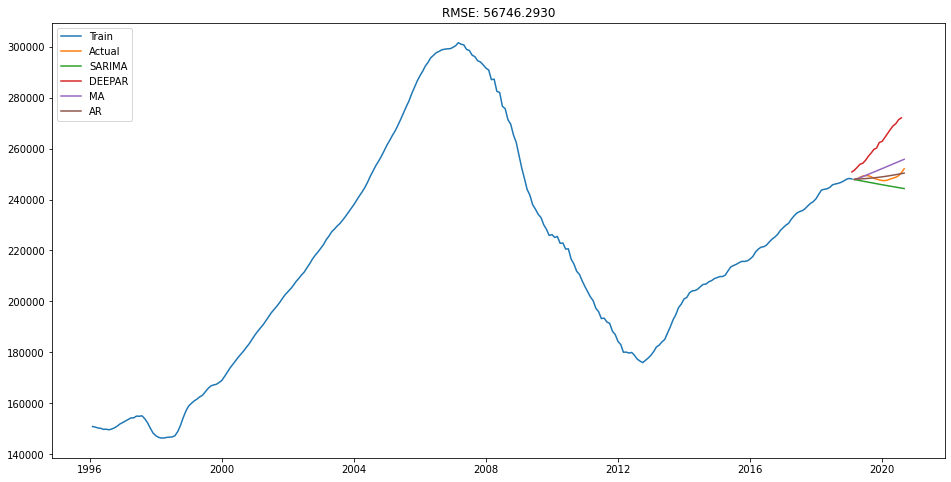

In [ ]:
plt.figure(figsize=(16,8))
plt.plot( train['139'], label='Train')
plt.plot(test['139'], label='Actual')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.plot(deepar_preds['0.5'], label='DEEPAR')
plt.plot(MA_predict, label='MA')
plt.plot(AR_predict, label='AR')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(y_hat_avg['SARIMA'], test['139']))/test.shape[0]))
plt.legend(loc='best')
plt.show()